 # Problem 2 - Assignment 3 - GPUs
 Implementation of two image kernels: Blur and Sobel filters.
 Blur is implemented in two ways: Box blur and Gaussian blur.

* Go to "Runtime" in the top menu.
* Select "Change runtime type".*
* Choose "T4 GPU" from the "Hardware accelerator" dropdown menu.
* Click "SAVE".

In [ ]:
#  verify GPU availability and its specifications
!nvidia-smi

Thu Mar 21 16:18:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float32
import PIL
from PIL import Image
import math

In [ ]:
def create_box_filter(filter_size):
    # Generate the box filter
    box_filter = np.ones((filter_size, filter_size), dtype=np.float64)
    box_filter /= np.sum(box_filter)
    return box_filter

def create_gaussian_filter(filter_size, sigma = 1, mu = 0):
    # Generate the Gaussian filter
    radius = filter_size // 2
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    r = np.sqrt(x**2 + y**2)
    sigma = 1.0
    s = 2 * sigma**2
    gaussian_filter = np.exp(-r / s) / (np.pi * s)
    gaussian_filter /= np.sum(gaussian_filter)
    return gaussian_filter

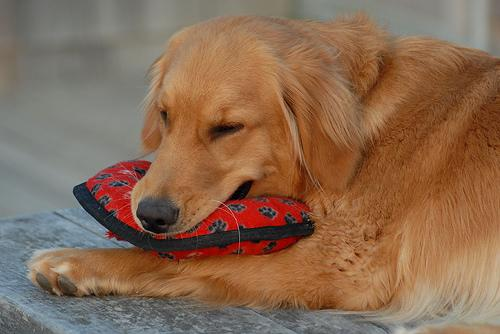

In [ ]:
path = "/content/2.jpg"
img = Image.open(path)
display(img)

In [ ]:
# Create filters
filter_size = 5

box_filter = create_box_filter(filter_size)
gaussian_filter = create_gaussian_filter(filter_size)

print("Filter size: ", filter_size)

if (filter_size < 9):
  print("Box Filter:")
  print(box_filter)
  print("\nGaussian Filter:")
  print(gaussian_filter)

Filter size:  5
Box Filter:
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]

Gaussian Filter:
[[0.0232475  0.03126119 0.03517766 0.03126119 0.0232475 ]
 [0.03126119 0.04714861 0.05799816 0.04714861 0.03126119]
 [0.03517766 0.05799816 0.0956228  0.05799816 0.03517766]
 [0.03126119 0.04714861 0.05799816 0.04714861 0.03126119]
 [0.0232475  0.03126119 0.03517766 0.03126119 0.0232475 ]]


## 2D convolution

In [ ]:
def apply_2d_convolution(img, filter):
    # Performs 2D convolution, this is the most similar version to the C++ code
    if len(img.shape) == 3:  # Color image
        rows, cols, c = img.shape
    elif len(img.shape) == 2:  # Grayscale image
        rows, cols = img.shape
    else:
        raise ValueError("Unsupported image shape")

    # Initialize output
    output = np.zeros_like(img)

    # Get filter dimensions
    filter_height, filter_width = filter.shape
    radius = min(filter_height // 2, filter_width // 2)

    for i in range(rows):
        for j in range(cols):
            for k in range(filter_height):
                for l in range(filter_width):
                    y = j - radius + l
                    x = i - radius + k
                    if x >= 0 and y >= 0 and x < rows and y < cols:
                        if len(img.shape) == 3:  # Color image
                            for ch in range(c):
                                output[i, j, ch] += img[x, y, ch] * filter[k, l]
                        elif len(img.shape) == 2:  # Grayscale image
                            output[i, j] += img[x, y] * filter[k, l]

    # Ensure that all values are between 0 and 255 and of uint8 type
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

In [ ]:
def apply_2d_convolution_np(image, filter):
    # Performs 2D convolution, using vector operations
    if len(image.shape) == 3:  # Color image
        num_channels = image.shape[2]
    elif len(image.shape) == 2:  # Grayscale image
        num_channels = 1
    else:
        raise ValueError("Unsupported image shape")

    # Get filter and image shape
    filter_height, filter_width = filter.shape
    image_height, image_width = image.shape[:2]

    # Initialize output
    output = np.zeros_like(image)

    # Pad the image to deal with borders
    pad_height = filter_height // 2
    pad_width = filter_width // 2
    if num_channels > 1:
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    else:
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            if num_channels > 1:  # Color image
                for c in range(num_channels):
                    output[i, j, c] = np.sum(padded_image[i:i+filter_height, j:j+filter_width, c] * filter)
            else:  # Grayscale image
                output[i, j] = np.sum(padded_image[i:i+filter_height, j:j+filter_width] * filter)

    # Ensure that all values are between 0 and 255 and of uint8 type
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

Original image shape:  (334, 500, 3)
Result shape (box): (334, 500, 3)
Result shape (gaussian): (334, 500, 3)
Filter size = 5


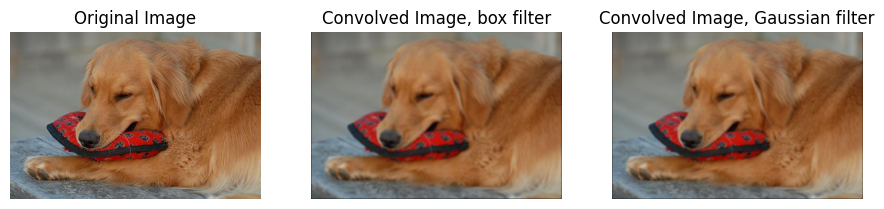

In [ ]:
# Box and gaussian filters on color image
# Define the input image
image = Image.open(path)
image_array = np.array(image)

# Apply convolution to image
result = apply_2d_convolution_np(image_array, box_filter)
print("Original image shape: ", image_array.shape)
print("Result shape (box):", result.shape)

# Apply convolution to image
result_g = apply_2d_convolution_np(image_array, gaussian_filter)
print("Result shape (gaussian):", result_g.shape)

print(f'Filter size = {filter_size}')
# Display the original and convolved color images
plt.figure(figsize=(11, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Convolved Image, box filter")
plt.imshow(result)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Convolved Image, Gaussian filter")
plt.imshow(result_g)
plt.axis('off')
plt.show()

Original grayscale image shape:  (334, 500)
Result grayscale shape (box): (334, 500)
Result grayscale shape (gaussian): (334, 500)
Filter size = 5


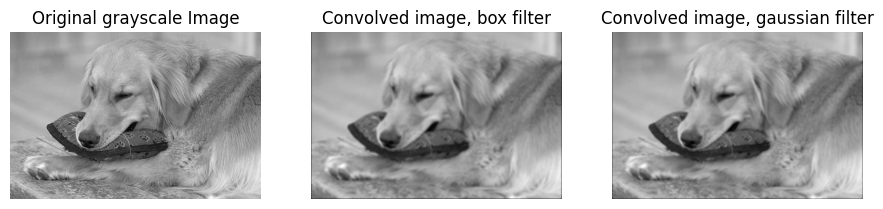

In [ ]:
# Box and gaussian filter on gray image
# Define the input image (grayscale)
gray_image = Image.open(path).convert("L")
gray_image_array = np.array(gray_image)

# Apply convolution to grayscale image
result_gray = apply_2d_convolution_np(gray_image_array, box_filter)
print("Original grayscale image shape: ", gray_image_array.shape)
print("Result grayscale shape (box):", result_gray.shape)

# Apply convolution to grayscale image
result_gray_g = apply_2d_convolution_np(gray_image_array, gaussian_filter)
print("Result grayscale shape (gaussian):", result_gray_g.shape)

print(f'Filter size = {filter_size}')
# Display the original and convolved grayscale images
plt.figure(figsize=(11, 5))
plt.subplot(1, 3, 1)
plt.title("Original grayscale Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Convolved image, box filter")
plt.imshow(result_gray, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Convolved image, gaussian filter")
plt.imshow(result_gray_g, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Using regular loops - BOX - very slow
print("Using loops, box filter, filter size: ", filter_size)
%timeit apply_2d_convolution(image_array, box_filter)

# Using numpy - BOX
print("Using numpy, box filter, filter size: ", filter_size)
%timeit apply_2d_convolution_np(image_array, box_filter)

# Using regular loops - GAUSSIAN - very slow
print("Using loops, gaussian filter, filter size: ", filter_size)
%timeit apply_2d_convolution(image_array, gaussian_filter)

# Using numpy - GAUSSIAN
print("Using numpy, gaussian filter, filter size: ", filter_size)
%timeit apply_2d_convolution_np(image_array, gaussian_filter)

Using loops, box filter, filter size:  5
16.1 s ± 539 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using numpy, box filter, filter size:  5
3.37 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using loops, gaussian filter, filter size:  5
16 s ± 598 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using numpy, gaussian filter, filter size:  5
3.34 s ± 406 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## CUDA

In [ ]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, color

@cuda.jit
def convolution_kernel(image, filter, output):
    # Get the thread's position in the grid
    i, j = cuda.grid(2)
    if i < image.shape[0] and j < image.shape[1]:
        # Iterate over each channel
        for c in range(image.shape[2]):
            tmp = 0.0
            for k in range(filter.shape[0]):
                for l in range(filter.shape[1]):
                    ii = i + k - filter.shape[0] // 2
                    jj = j + l - filter.shape[1] // 2
                    if ii >= 0 and ii < image.shape[0] and jj >= 0 and jj < image.shape[1]:
                        tmp += image[ii, jj, c] * filter[k, l]
            output[i, j, c] = tmp

def cuda_convolution(image, filter):
    # Allocate device memory and copy data
    d_image = cuda.to_device(image)
    d_filter = cuda.to_device(filter)

    # Allocate output device memory
    output = np.zeros_like(image)

    # Configure the grid and block sizes
    threadsperblock = (16, 16)
    # The following lines allow to split the image equally
    blockspergrid_x = (image.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (image.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Launch the kernel
    convolution_kernel[blockspergrid, threadsperblock](d_image, d_filter, output)

    # Ensure that all values are between 0 and 255 and of uint8 type
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Filter size = 5


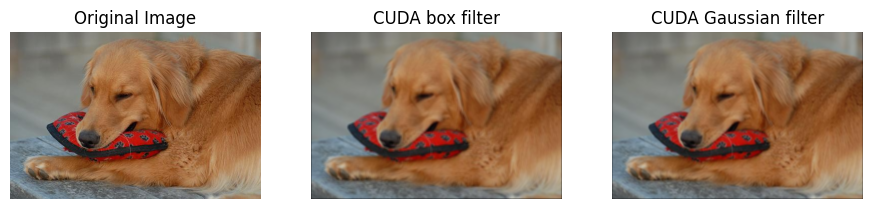

In [ ]:
# Perform CUDA convolution on color image
output_color = cuda_convolution(image_array, box_filter)
output_color_g = cuda_convolution(image_array, gaussian_filter)

print(f'Filter size = {filter_size}')
# Display the original and convolved images
plt.figure(figsize=(11, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("CUDA box filter")
plt.imshow(output_color)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("CUDA Gaussian filter")
plt.imshow(output_color_g)
plt.axis('off')
plt.show()

## Sobel filter

In [ ]:
def sobel_tot(gray_image):
  # Applies sobel edge detection both horizzontaly and vertically
  sobel_x = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]]) # x direction
  sobel_y = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]]) # y direction
  # Convert gray image to numpy array
  gray_image_array = np.array(gray_image)
  #Get image shape
  [rows, columns] = np.shape(gray_image_array)
  # Initialize output
  output = np.zeros_like(gray_image)

  for i in range(rows - 2):
      for j in range(columns - 2):
          gx = np.sum(np.multiply(sobel_x, gray_image_array[i:i + 3, j:j + 3]))
          gy = np.sum(np.multiply(sobel_y, gray_image_array[i:i + 3, j:j + 3]))
          # magnitude
          output[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)
  # Ensure that all values are between 0 and 255 and of uint8 type
  output = np.clip(output, 0, 255).astype(np.uint8)
  return output

Sobel filter, both directions


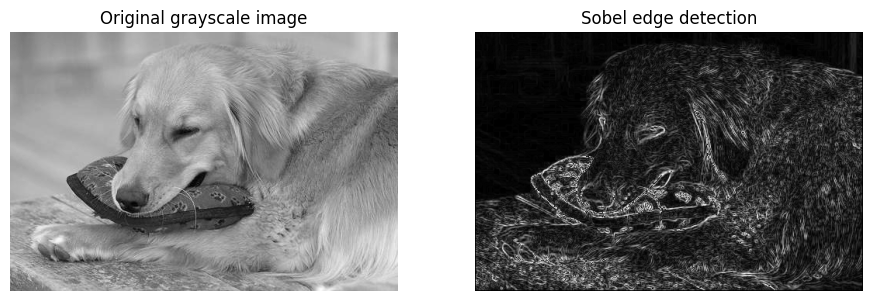

In [ ]:
# Display the original image and the Sobel filtered image
sobel = sobel_tot(gray_image)
print(f'Sobel filter, both directions')
# Display the original and convolved images
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title("Original grayscale image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Sobel edge detection")
plt.imshow(sobel, cmap='gray')
plt.axis('off')
plt.show()

## CUDA Sobel

In [ ]:
@cuda.jit
def sobel_tot_kernel(gray_image, output, sobel_x, sobel_y):

    i, j = cuda.grid(2)  # Get the thread's position in the grid

    if i < gray_image.shape[0] - 2 and j < gray_image.shape[1] - 2:
        tmp_x = 0.0
        tmp_y = 0.0
        for m in range(3):
            for n in range(3):
                tmp_x += sobel_x[m, n] * gray_image[i + m, j + n]
                tmp_y += sobel_y[m, n] * gray_image[i + m, j + n]

        # magnitude
        output[i + 1, j + 1] = math.sqrt(tmp_x ** 2 + tmp_y ** 2)
        output[i + 1, j + 1] = min(max(output[i + 1, j + 1], 0), 255)  # clip output

def sobel_tot_cuda(gray_image):
    gray_image_array = np.array(gray_image, dtype=np.float32)
    output = np.zeros_like(gray_image_array, dtype=np.float32)

    s_x = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]]) # x direction
    s_y = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]]) # y direction
    sobel_x = cuda.to_device(s_x)
    sobel_y = cuda.to_device(s_y)

    threadsperblock = (16, 16)  # Define the number of threads per block
    # The following lines allow to split the image equally
    blockspergrid_x = (gray_image_array.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (gray_image_array.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)  # Define the number of blocks per grid

    sobel_tot_kernel[blockspergrid, threadsperblock](gray_image_array, output, sobel_x, sobel_y)

    return output

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Sobel filter, both directions


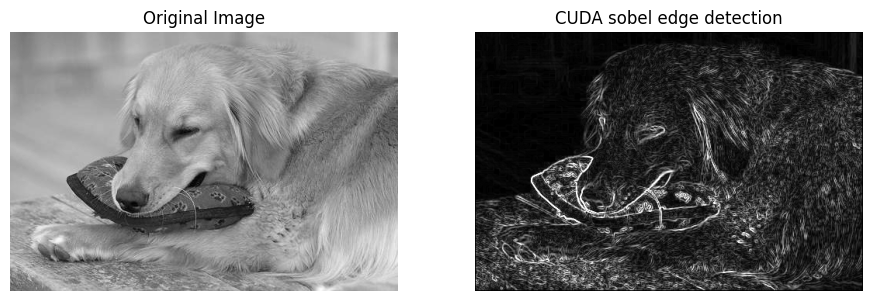

In [ ]:
# Perform CUDA convolution on color image
output_sobel = sobel_tot_cuda(gray_image)

print(f'Sobel filter, both directions')
# Display the original and convolved images
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("CUDA sobel edge detection")
plt.imshow(output_sobel, cmap='gray')
plt.axis('off')
plt.show()

## TimeIt results

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Create filters
filter_size = [9, 11, 13]

for size in filter_size:
  box_filter = create_box_filter(size)
  gaussian_filter = create_gaussian_filter(size)

  print("\n \033[1mFilter size: \033[0m", size)
  # Sobel edge detection
  print("\nSobel edge detection")
  %timeit sobel_tot(gray_image)

  # Sobel edge detection - CUDA
  print("\nSobel edge detection, CUDA")
  %timeit sobel_tot_cuda(gray_image)

  # Using CUDA - BOX
  print("\nUsing CUDA, box filter")
  %timeit cuda_convolution(image_array, box_filter)

  # Using CUDA - GAUSSIAN
  print("\nUsing CUDA, gaussian filter")
  %timeit cuda_convolution(image_array, gaussian_filter)

  # Using numpy - BOX
  print("\nUsing numpy, box filter")
  %timeit apply_2d_convolution_np(image_array, box_filter)

  # Using numpy - GAUSSIAN
  print("\nUsing numpy, gaussian filter")
  %timeit apply_2d_convolution_np(image_array, gaussian_filter)


# Reset warnings filter to default behavior
warnings.resetwarnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 Filter size:  9

Sobel edge detection
2.4 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Sobel edge detection, CUDA
2.58 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using CUDA, box filter
2.62 ms ± 99.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using CUDA, gaussian filter
2.58 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using numpy, box filter
3.57 s ± 437 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Using numpy, gaussian filter
3.53 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 Filter size:  11

Sobel edge detection
2.38 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Sobel edge detection, CUDA
2.85 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using CUDA, box filter
2.86 ms ± 69.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Using CUDA, gaussian filter
2.83 ms ± 45.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Usi